In [1]:
import tensorflow as tf
import numpy as np 
import os

from tensorflow.keras.mixed_precision import experimental as mixed_precision

/Users/hyunkim/.pyenv/versions/3.6.9/envs/python36/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from fast_scnn import fastSCNN, fastSCNN_edition2
from fast_scnn import *
from network import network_big

In [3]:
model_path = "./trained_models/20200828/1179_0.08.h5"

In [4]:
input_shape=(256, 192, 3)

In [5]:
model = fastSCNN(input_shape, train=False)
model.load_weights(model_path, by_name=True)
print(model.output)
# model = network_big(input_shape, train=False)

Tensor("conv2d_35/Sigmoid:0", shape=(None, 256, 192, 1), dtype=float32)


In [6]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 96, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 96, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 96, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
# model.summary()

In [7]:
withGraph_model = model_path.replace(".h5", "_withGraph.h5")
model.save(withGraph_model)

**실행 시간 체크**

In [19]:
x = np.random.random(size=(1,) + input_shape)

In [20]:
%%timeit
pred = model.predict(x)

57.9 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Sample test

In [23]:
import matplotlib.pyplot as plt

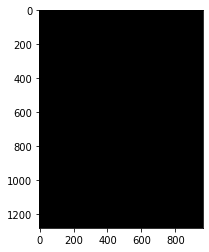

In [24]:
import cv2
from preprocess import scale

img_file = "/Users/MAC/Downloads/photo_2020-09-25 14.46.53.jpeg"
img = cv2.imread(img_file, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

re_img = cv2.resize(img, (192, 256))
in_img = scale(re_img[np.newaxis,:,:,:])

pred = model.predict(in_img)

plt.imshow(np.uint(img * np.expand_dims(cv2.resize(pred[0][0], dsize=(960, 1280)), -1)))

### To Convert TFJS model

In [10]:
tf_saved = model_path.replace(".h5", "_InTF_savedModel")

In [11]:
# save tf-saved model
tf.saved_model.save(model, tf_saved)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./trained_models/20200828/1179_0.08_InTF_savedModel/assets


In [ ]:
### import tensorflowjs
tensorflowjs.converters.convert_tf_saved_model(tf_saved, model_path.replace(".h5", "_tfjs_models"))

### To Conver TFLITE model

In [13]:
tflite_file_name = model_path.replace(".h5", "_tflite.tflite")
tflite_file_name_4channel = model_path.replace(".h5", "_4channel_tflite.tflite")

In [14]:
############ 3channel ##########################
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

with open(tflite_file_name, "wb") as f:
    f.write(tflite_model)
    
############ 4channel ##########################
model_4channel = fastSCNN(input_shape, train=True, android=True)
model_4channel.load_weights(model_path, by_name=False)
model_4channel = tf.keras.models.Model(model_4channel.input, model_4channel.output[0])

converter = tf.lite.TFLiteConverter.from_keras_model(model_4channel)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

with open(tflite_file_name_4channel, "wb") as f:
    f.write(tflite_model)

### To Conver mlmodel


In [15]:
import coremltools

In [16]:
coreml_model_file = model_path.replace(".h5", "_coreml.mlmodel")

In [17]:
ml_model = coremltools.converters.tensorflow.convert(withGraph_model,
                                                input_names='input_1', 
                                                image_input_names='input_1', 
                                                red_bias = -(123.68) / 58.393,
                                                green_bias = -(116.779) / 57.12, 
                                                blue_bias = -(103.939) / 57.375,
                                                image_scale = 1.0 / 57.63,
                                                custom_conversion_functions={"BilinearInterpolation":BilinearInterpolation}
                                               )
ml_model.save(coreml_model_file)

0 assert nodes deleted
297 nodes deleted
150 nodes deleted
0 nodes deleted
[Op Fusion] fuse_bias_add() deleted 88 nodes.
1 identity nodes deleted
36 disconnected nodes deleted
[Op Fusion] Fused 294 nodes into BatchNorms.
[SSAConverter] Converting function main ...
[SSAConverter] [1/198] Converting op type: 'Placeholder', name: 'input_1', output_shape: (-1, 256, 192, 3).
[SSAConverter] [2/198] Converting op type: 'Const', name: 'model/depthwise_conv2d/depthwise/ReadVariableOp', output_shape: (3, 3, 32, 1).
[SSAConverter] [3/198] Converting op type: 'Const', name: 'model/depthwise_conv2d_1/depthwise/ReadVariableOp', output_shape: (3, 3, 48, 1).
[SSAConverter] [4/198] Converting op type: 'Const', name: 'model/depthwise_conv2d_2/depthwise/ReadVariableOp', output_shape: (3, 3, 384, 1).
[SSAConverter] [5/198] Converting op type: 'Const', name: 'model/depthwise_conv2d_3/depthwise/ReadVariableOp', output_shape: (3, 3, 384, 1).
[SSAConverter] [6/198] Converting op type: 'Const', name: 'model/de

[SSAConverter] [101/198] Converting op type: 'BatchNorm', name: 'model/batch_normalization_23/FusedBatchNormV3/Add_batch_norm', output_shape: (-1, 576, 8, 6).
[SSAConverter] [102/198] Converting op type: 'Relu', name: 'model/activation_17/Relu', output_shape: (-1, 576, 8, 6).
[SSAConverter] [103/198] Converting op type: 'DepthwiseConv2dNative', name: 'model/depthwise_conv2d_8/depthwise', output_shape: (-1, 576, 8, 6).
[SSAConverter] [104/198] Converting op type: 'BatchNorm', name: 'model/batch_normalization_24/FusedBatchNormV3/Add_batch_norm', output_shape: (-1, 576, 8, 6).
[SSAConverter] [105/198] Converting op type: 'Relu', name: 'model/activation_18/Relu', output_shape: (-1, 576, 8, 6).
[SSAConverter] [106/198] Converting op type: 'Conv2D', name: 'model/conv2d_16/Conv2D', output_shape: (-1, 128, 8, 6).
[SSAConverter] [107/198] Converting op type: 'BatchNorm', name: 'model/batch_normalization_25/FusedBatchNormV3/Add_batch_norm', output_shape: (-1, 128, 8, 6).
[SSAConverter] [108/198]

/Users/MAC/.pyenv/versions/3.6.9/envs/tf20/lib/python3.6/site-packages/coremltools/models/model.py:112: RuntimeWarning: You will not be able to run predict() on this Core ML model. Underlying exception message was: Error compiling model: "Error reading protobuf spec. validator error: The .mlmodel supplied is of version 4, intended for a newer version of Xcode. This version of Xcode supports model version 3 or earlier.".
  RuntimeWarning)
